In [1]:
from pathlib import Path


EVENTS = Path('../data/raw/e2vid/hdr_selfie.txt')

In [2]:
from dynamic_fusion.scripts.test_e2vid_data import get_events_from_txt

events, height, width = get_events_from_txt(EVENTS)

/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Integer column has NA values in column 2

In [16]:
import numpy as np


bin_size = 0.05

number_of_temporal_bins = int(np.ceil((events.timestamp.max() / bin_size)))
max_t = number_of_temporal_bins * bin_size

In [17]:
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration

config = EventDiscretizerConfiguration(number_of_temporal_bins=number_of_temporal_bins, number_of_temporal_sub_bins_per_bin=1)

discretizer = EventDiscretizer(config, max_timestamp=max_t)
size = (events.x.max() + 1, events.y.max() + 1 )

discretized_events = discretizer.run({1: events}, (size[1], size[0]))
discretized_events = discretized_events[1]

(array([3468264., 3926989., 6327221., 4921750., 4352484., 3244388.,
        3061491., 3425546., 3234562., 3986212.]),
 array([0.    , 0.5169, 1.0338, 1.5507, 2.0676, 2.5845, 3.1014, 3.6183,
        4.1352, 4.6521, 5.169 ]),
 <BarContainer object of 10 artists>)

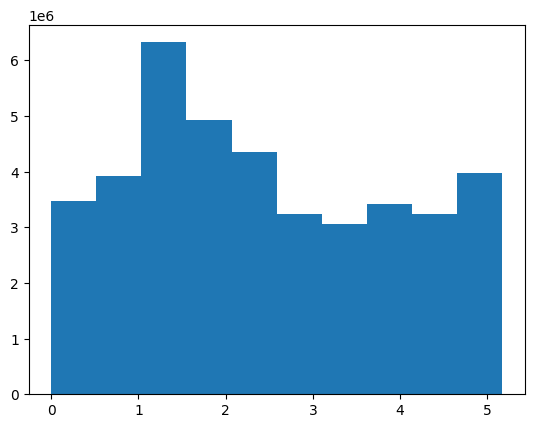

In [18]:
from matplotlib import pyplot as plt
plt.hist(events.timestamp)

In [19]:
len(events) / events.timestamp.max() / (events.x.max() + 1) / (events.y.max() + 1)

25.15806054826048

In [20]:
from matplotlib import pyplot as plt
import numpy as np

from dynamic_fusion.utils.network import to_numpy
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap
import cv2


out = cv2.VideoWriter("real_selfie.mp4", cv2.VideoWriter.fourcc(*"mp4v"), 10, size)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)  # White color
line_type = 2
position = (10, 50)  # Position of the text (bottom left corner)


for i, eps in enumerate(discretized_events.event_polarity_sum):
    colored_event_polarity_sum = img_to_colormap(to_numpy(eps.sum(dim=0)), create_red_blue_cmap(501))

    evr = discretized_events.event_count[i].sum(dim=0).mean()

    frame_processed = (colored_event_polarity_sum[::-1] * 255).astype(np.uint8)


    cv2.putText(frame_processed, f"Events per frame per pixel={evr:.2f}", position, font, font_scale, font_color, line_type)

    out.write(frame_processed)
out.release()
